In [22]:
# HW1Q3Qiskit.ipynb
# Date: 07/30/2021
# Author: Rio Weil
# Functionality: Simulates a 9-qubit shor code to numerically estimate the concatenation threshold under depolarizing Pauli noise applied individually to each qubit.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile, assemble
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import pauli_error, depolarizing_error, thermal_relaxation_error
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram

Before we get into the 9-qubit Shor code, we first introduce how we can implement a repetition code in Qiskit such that we can perform error correction without performing syndrome measurements and correction procedures (we will show how the correction procedure can in a sense be "built in" to the circuit itself, and performed unitarily). First, let's take a look at what the bit flip repetition code looks like.

In [2]:
simulator = QasmSimulator()
circuit = QuantumCircuit(3, 3)
circuit.cx(0, 1)
circuit.cx(0, 2)
circuit.barrier()
circuit.x(0)
circuit.x(1)
circuit.x(2)
circuit.barrier()
circuit.cx(0, 1)
circuit.cx(0, 2)
circuit.ccx(2, 1, 0)
circuit.draw()

░ ┌───┐ ░           ┌───┐
q_0: ──■────■───░─┤ X ├─░───■────■──┤ X ├
     ┌─┴─┐  │   ░ ├───┤ ░ ┌─┴─┐  │  └─┬─┘
q_1: ┤ X ├──┼───░─┤ X ├─░─┤ X ├──┼────■──
     └───┘┌─┴─┐ ░ ├───┤ ░ └───┘┌─┴─┐  │  
q_2: ─────┤ X ├─░─┤ X ├─░──────┤ X ├──■──
          └───┘ ░ └───┘ ░      └───┘     
c: 3/════════════════════════════════════

Note that We inject the state $\lvert \psi \rangle$ at $q_0$ and $\lvert 0 \rangle$ at $q_1, q_2$ and read it out the state at the end at $q_0$. The probabilistic errors are represented in the above circuit with the X gates in the center. We now discuss how this circuit allows us to correct for bit flip errors (in particular, the Toffli gate at the end will perform the error correction for us).

We first discuss state preparation. In general, we can make the identification $\lvert \psi \rangle = \alpha\lvert 0 \rangle + \beta \lvert 1 \rangle = \begin{bmatrix} \alpha \\ \beta \end{bmatrix}$ and consider what happens to the other qubits. However, we will find it sufficient to discuss the cases $\lvert \psi \rangle = \lvert 0 \rangle$ and $\lvert \psi \rangle = \lvert 1 \rangle$ (as if we can see error correction in these two cases, we could conclude error correction in the other two cases via taking linear combinations.

Let us start with $\lvert \psi \rangle = \lvert 0 \rangle$. Then, the qubits $q_1$ and $q_2$ are unaffected under the initial two CNOT gates as the control qubit is in state $0$. Hence, the state of the three qubits before the error is just $\lvert 0 0 0 \rangle = \lvert 0 \rangle_0 \otimes \lvert 0 \rangle_1 \otimes \lvert 0 \rangle_2$.

Then, we have 8 cases to consider with the probabilistic bit flips on the code qubits:

1. No bit flip on any qubit
2. Bit flip on $q_0$ only
3. Bit flip on $q_1$ only
4. Bit flip on $q_2$ only
5. Bit flips on $q_0$, $q_1$
6. Bit flips on $q_0$, $q_2$
7. Bit flips on $q_1$, $q_2$
8. Bit flips on all three

If the bit flip is to work as intended, we should see error correction/the correct state readout from qubit $q_0$ at the end for cases 1-4 and an error for cases 5-8.

1. In this case, we have that no bit flip errors occur on the qubits. Hence, the qubit states will all still be individually $\lvert 0 \rangle$ at the end, and the CNOT/Toffili gates at the end will have no affect on the states (control qubits are all zero). Hence, the final state of the $q_0$ qubit will be $\lvert 0 \rangle$ (same as the initial state!) exactly as we require.

2. In this case, we have a bit flip error on $q_0$. Hence, the state of the first qubit after the error section is $\lvert 1 \rangle$. Then, the two CNOTs after the errors will bit flip $q_1$ and $q_2$ respectively. After the two CNOT gates, the state of the qubits is $\lvert 1 1 1 \rangle = \lvert 1 \rangle_0 \otimes \lvert 1 \rangle_1 \otimes \lvert 1 \rangle_2$. Then, the Toffili gate will invert the first qubit, as the two control qubits $q_1$ and $q_2$ are both in the $\lvert 1 \rangle$ state. This means the final state of $q_0$ will be $\lvert 0 \rangle$, exactly as we require.

3. In this case, we have a bit flip error on $q_1$, so the state of the first qubit after the error is $\lvert 1 \rangle$. Then, the CNOTs do not result in any flips as the control qubit $q_0$ is still $\lvert 0 \rangle$. The Toffili gate does not invert $q_0$ as $q_2$ is still in the 0 state, though $q_1$ is in the one state (it requires that both control qubits be in the 1 state). Hence the final state of $q_0$ will be $\lvert 0 \rangle$.

4. The analysis for this case is identical to case 3; we again find that the final state of $q_0$ is $\lvert 0 \rangle$.

5. In this case, after the error we have that the state is $\lvert 110 \rangle$. Then, the first CNOT will have the effect of flipping $q_1$ to make the state $\lvert 100 \rangle$ and the second CNOT will have the effect of flipping $q_2$ to make the state $\lvert 101 \rangle$. The Toffili gate does not invert $q_0$ as one of the control qubits ($q_1$) is not in the 1 state. Hence the final state of $q_0$ is $\lvert 1 \rangle$, so a logical error occurs.

6. In this case, after the error we have that the state is $\lvert 101 \rangle$. Then, the first CNOT gate will have the effect of flipping $q_1$ to make the state $\lvert 111 \rangle$, and the second CNOT will have the effect of flipping $q_2$ to make the state $\lvert 110 \rangle$. The Toffili gate does not invert $q_0$ as one of the control qubits ($q_2$) is not in the 1 state. Hence the final state of $q_0$ is $\lvert 1 \rangle$, so a logical error occurs.

7. In this case, after the error we have that the state is $\lvert 011 \rangle$. Neither CNOT gates will have an effect as the control qubit $q_0$ is in the 0 state. The Toffili gate inverts $q_0$ as both of the control qubits are in the 1 state, making the final state of $q_0$ to be $\lvert 1 \rangle$, so a logical error occurs.

8. In this case, after the error we have that the state is $\lvert 111 \rangle$. The CNOT gates flip both $q_1$ and $q_2$ as the control qubit is in the 1 state, making the state $\lvert 100 \rangle$. Then, the Toffili gate does not flip the first qubit as both control qubits are in the 0 state, so we end with $q_0$ in the $\lvert 1 \rangle$ state and an error occurs.

From this discussion, we see that the repetition code can error correct for single qubit errors in the case that the initial state is $\lvert 0 \rangle$. To complete the argument, we now consider an initial state of $q_0$ to be $\lvert 1 \rangle$. Then, the action of the CNOT gates in the beginning is such that both $q_1$ and $q_2$ get bit flipped as the control qubit is in the 1 state; hence, the state of the three qubits before the error is $\lvert 1 1 1 \rangle = \lvert 1 \rangle_0 \otimes \lvert 1 \rangle_1 \otimes \lvert 1 \rangle_2$. We could go through the analysis again, but instead we can just observe that cases 1-4 (either 0 or 1 bit flips) for the initial $\lvert 1 \rangle$ state correspond to cases 5-8 (2 or 3 bit flips) for the initial $\lvert 0 \rangle$ state. In cases 5-8 above, we indeed see that the final state is $\lvert 1 \rangle$ and hence for an initial state of $\lvert \psi \rangle = \lvert 1 \rangle$ we see that the circuit has the intended effect of correcting errors for single qubit errors, and having a logical error for 2/3 qubit errors.

With this discussion concluded, we now move onto the code for the Shor code and look at the results! To implement the Shor code, we can simply implement the above repetition code (with error correction!) at each level of encoding (e.g. a phase flip repetion code at the first level w/ error correction for single qubit phase flips, three bit flip repetition code at the second level w/ error corrections for single qubit (per block) bit flips). Let's see what the results will be!

In [6]:
def pauli_depol_noise(p):
    depol_error = pauli_error([('X',p/3), ('Y', p/3), ('Z', p/3), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(depol_error, "id") # Error applied to qubits when identity gate applied
    
    return noise_model

In [7]:
# Circuit where Shor code was applied
def simulateShor(p, numruns, returnCircuit = False):
    # Use Aer's qasm_simulator
    simulator = QasmSimulator()

    # Create a Quantum Circuit acting on the q register
    circuit = QuantumCircuit(9, 9)

    # Establishes noise model
    noise_model = pauli_depol_noise(p)

    # First part of Shor Code
    circuit.cx(0,3)
    circuit.cx(0,6)

    circuit.h(0)
    circuit.h(3)
    circuit.h(6)

    circuit.cx(0,1)
    circuit.cx(3,4)
    circuit.cx(6,7)

    circuit.cx(0,2)
    circuit.cx(3,5)
    circuit.cx(6,8)

    circuit.barrier()

    ####error here############
    for i in range(9):
        circuit.id(i)
    ############################

    circuit.barrier()

    # Second part of Shor Code
    circuit.cx(0,1)
    circuit.cx(3,4)
    circuit.cx(6,7)

    circuit.cx(0,2)
    circuit.cx(3,5)
    circuit.cx(6,8)

    circuit.ccx(1,2,0)
    circuit.ccx(4,5,3)
    circuit.ccx(8,7,6)

    circuit.h(0)
    circuit.h(3)
    circuit.h(6)

    circuit.cx(0,3)
    circuit.cx(0,6)
    circuit.ccx(6,3,0)

    circuit.barrier()
    circuit.measure(0,0)
    # compile the circuit down to low-level QASM instructions
    # supported by the backend (not needed for simple circuits)
    compiled_circuit = transpile(circuit, simulator)
    
    if(returnCircuit):
        return circuit.draw()
    else:
        # Execute the circuit on the qasm simulator
        job = simulator.run(compiled_circuit, noise_model=noise_model, shots=numruns)

        # Grab results from the job
        result = job.result()

        # Returns counts
        counts = result.get_counts(circuit)
        #print("\nTotal count of measurements are:",counts)

        return counts

In [8]:
# Circuit where Shor code was not applied
def simulateNoShor(p, numruns, returnCircuit = False):
    # Use Aer's qasm_simulator
    simulator = QasmSimulator()
    
    # Builds circuit with one qubit
    circuit = QuantumCircuit(1, 1)
    
    # Establishes noise model
    noise_model = pauli_depol_noise(p)

    # Applies identity gate (with depolarizing noise on it, as specified by error model)
    circuit.id(0)

    # Measures qubit
    circuit.measure(0,0)

    # compile the circuit down to low-level QASM instructions
    compiled_circuit = transpile(circuit, simulator)
    
    if (returnCircuit):
        return circuit.draw()
    else:
        # Execute the circuit on the qasm simulator
        job = simulator.run(compiled_circuit, noise_model=noise_model, shots=numruns)

        # Grab results from the job
        result = job.result()

        # Returns counts
        counts = result.get_counts(circuit)
        #print("\nTotal count of measurements are:",counts)

        return counts

Since our qubit starts out in state $\lvert\psi\rangle = \lvert 0 \rangle$, the depolarizing channel will create an error if an $X$ or $Y$ gate is applied (flipping the bit). Hence, for the case where we did not use the Shor code/no error correcting procedure, we would expect a $2p/3$ probability of error (measuring a $1$ instead of a $0$).

In [10]:
simulateNoShor(0.5, 1000, True)

┌───┐┌─┐
q_0: ┤ I ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

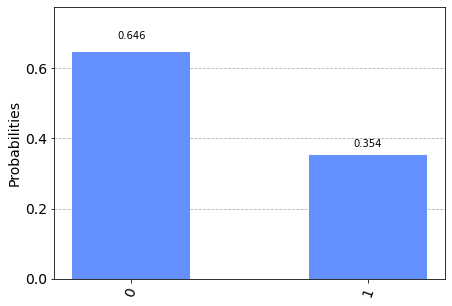

In [11]:
plot_histogram(simulateNoShor(0.5, 1000))

Next, we visualize and see the results for the Shor code:

In [12]:
simulateShor(0.5, 1000, True)

┌───┐           ░ ┌───┐ ░           ┌───┐┌───┐          ┌───┐ ░ »
q_0: ──■────■──┤ H ├──■────■───░─┤ I ├─░───■────■──┤ X ├┤ H ├──■────■──┤ X ├─░─»
       │    │  └───┘┌─┴─┐  │   ░ ├───┤ ░ ┌─┴─┐  │  └─┬─┘└───┘  │    │  └─┬─┘ ░ »
q_1: ──┼────┼───────┤ X ├──┼───░─┤ I ├─░─┤ X ├──┼────■─────────┼────┼────┼───░─»
       │    │       └───┘┌─┴─┐ ░ ├───┤ ░ └───┘┌─┴─┐  │         │    │    │   ░ »
q_2: ──┼────┼────────────┤ X ├─░─┤ I ├─░──────┤ X ├──■─────────┼────┼────┼───░─»
     ┌─┴─┐  │  ┌───┐     └───┘ ░ ├───┤ ░      └───┘┌───┐┌───┐┌─┴─┐  │    │   ░ »
q_3: ┤ X ├──┼──┤ H ├──■────■───░─┤ I ├─░───■────■──┤ X ├┤ H ├┤ X ├──┼────■───░─»
     └───┘  │  └───┘┌─┴─┐  │   ░ ├───┤ ░ ┌─┴─┐  │  └─┬─┘└───┘└───┘  │    │   ░ »
q_4: ───────┼───────┤ X ├──┼───░─┤ I ├─░─┤ X ├──┼────■──────────────┼────┼───░─»
            │       └───┘┌─┴─┐ ░ ├───┤ ░ └───┘┌─┴─┐  │              │    │   ░ »
q_5: ───────┼────────────┤ X ├─░─┤ I ├─░──────┤ X ├──■──────────────┼────┼───░─»
          ┌─┴─┐┌───┐     └───┘ ░ ├───┤ ░      └───┘┌───┐┌───┐     ┌─┴─┐  │   ░ »
q_6: ─────┤ X ├┤ H ├──■────■───░─┤ I ├─░───■────■──┤ X ├┤ H ├─────┤ X ├──■───░─»
          └───┘└───┘┌─┴─┐  │   ░ ├───┤ ░ ┌─┴─┐  │  └─┬─┘└───┘     └───┘      ░ »
q_7: ───────────────┤ X ├──┼───░─┤ I ├─░─┤ X ├──┼────■───────────────────────░─»
                    └───┘┌─┴─┐ ░ ├───┤ ░ └───┘┌─┴─┐  │                       ░ »
q_8: ────────────────────┤ X ├─░─┤ I ├─░──────┤ X ├──■───────────────────────░─»
                         └───┘ ░ └───┘ ░      └───┘                          ░ »
c: 9/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«     ┌─┐
«q_0: ┤M├
«     └╥┘
«q_1: ─╫─
«      ║ 
«q_2: ─╫─
«      ║ 
«q_3: ─╫─
«      ║ 
«q_4: ─╫─
«      ║ 
«q_5: ─╫─
«      ║ 
«q_6: ─╫─
«      ║ 
«q_7: ─╫─
«      ║ 
«q_8: ─╫─
«      ║ 
«c: 9/═╩═
«      0

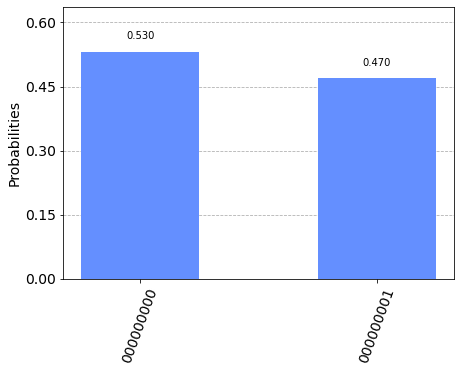

In [13]:
plot_histogram(simulateShor(0.5, 1000))

Above we have the circuits as well as the resulting measurement outcomes. We see that if $p = 0.5$, the Shor code performs worse than the case where we had no Code/error correction whatsoever. Evidently this is over the threshold. 

In [14]:
numruns = 5000
par = np.linspace(0.01, 1, 100)
noshorlist = []
shorlist = []

for p in par:
    noshorlist.append(simulateNoShor(p, numruns).get("1") / numruns)
    shorlist.append(simulateShor(p, numruns).get("000000001") / numruns)

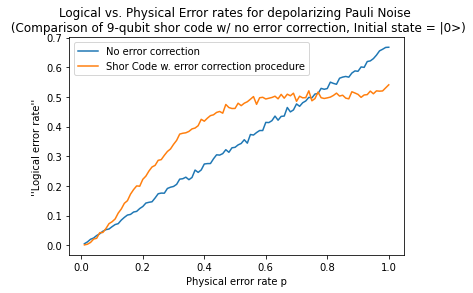

In [15]:
plt.plot(par, noshorlist, label = "No error correction")
plt.plot(par, shorlist, label = "Shor Code w. error correction procedure")
plt.xlabel("Physical error rate p")
plt.ylabel("''Logical error rate''")
plt.title("Logical vs. Physical Error rates for depolarizing Pauli Noise \n (Comparison of 9-qubit shor code w/ no error correction, Initial state = |0>)")
plt.legend(loc = "best")
plt.show()

Note that although we call it the "logical error rate" in the above plot, what is really plotted on the y-axis is the ratio of the 1 outcome measurement to the total number of measurements. For the state not affected by any error, we have the initial state in the eigenstate $\lvert 0 \rangle$ which returns the measurement outcome of 0 100% of the time. As we increase the physical error rate $p$ of the depolarizing Pauli noise, the chance of measuring outcome 1 will go up as error can affect the state. However, it is notable that what we have here isn't quite the logical error rate, as we are in a sense inferring the state from the measurement outcome (which is obviously false; we cannnot infer a quantum state from a single measurement in a fixed basis! Multiple measurements across multiple bases are required for this). So, we really are characterizing the error rate on the y-axis, rather than plotting it exactly. 

From the above plot, we find that the concatenation threshold is in the region between $p = 0.05$ and $p = 0.1$. Note that as $p \rightarrow 1$, in the case of no-error correction we have that the "logical error rate" goes to $0.66$ (which makes sense as only 2/3 of the errors, namely the X and Y errors, will have any effect on the initial state of $\lvert 0 \rangle$). However, for the case of the Shor code, we have that as $p \rightarrow 1$, the "logical error rate" goes to $0.5$, that is, we measure 0 and 1 outcomes with equal probability. By applying the Shor code and increasing the physical error rate, we in a sense maximally depolarize the quantum state such that both measurement outcomes are equally as likely. 

Again, we note that it's not actually possible to construct the logical error rate because what we can obtain from this simulation are really measurement outcomes; however, bounding/approximating the error rate certainly seems feasible. Let us run a more fine scan in the region where the two curves intersect, that is $p \in [0.05, 0.1]$.

In [17]:
numruns = 15000
par = np.linspace(0.05, 0.1, 100)
noshorlist = []
shorlist = []

for p in par:
    noshorlist.append(simulateNoShor(p, numruns).get("1") / numruns)
    shorlist.append(simulateShor(p, numruns).get("000000001") / numruns)

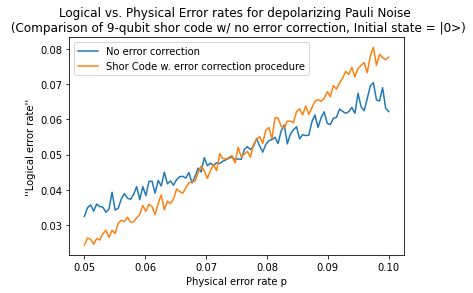

In [18]:
plt.plot(par, noshorlist, label = "No error correction")
plt.plot(par, shorlist, label = "Shor Code w. error correction procedure")
plt.xlabel("Physical error rate p")
plt.ylabel("''Logical error rate''")
plt.title("Logical vs. Physical Error rates for depolarizing Pauli Noise \n (Comparison of 9-qubit shor code w/ no error correction, Initial state = |0>)")
plt.legend(loc = "best")
plt.show()

From this, we estimate the concatenation threshold to be $p = 0.075 \pm 0.1$. 